In [1]:
%load_ext autoreload
%autoreload 

from preprocessing.preprocess_ucr import UCRDatasetImporter
from preprocessing.preprocess_ucr import UCRDataset
from preprocessing.preprocess_ucr import AugUCRDataset
from preprocessing.data_pipeline import build_data_pipeline
from utils import load_yaml_param_settings

from utils import time_to_timefreq, timefreq_to_time
from preprocessing.augmentations import TimeFreqAugmenter
import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy.ndimage import rotate
import torch.nn.functional as F
import math

/home/erlendlokna/Documents/ntnu/Generative-SSL-VQVAE-modelling/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
config = load_yaml_param_settings("configs/config.yaml")

config['dataset']['dataset_name'] = 'UWaveGestureLibraryAll'
config["VQVAE"]["n_fft"] = 8

# data pipeline
dataset_importer = UCRDatasetImporter(**config["dataset"])
batch_size = config["dataset"]["batch_sizes"]["stage1"]
train_data_loader = build_data_pipeline(
    batch_size, dataset_importer, config, "train", augment=False
)
test_data_loader = build_data_pipeline(batch_size, dataset_importer, config, "test")

augmenter = TimeFreqAugmenter(**config["augmentations"]["aug_params"])

self.X_train.shape: (896, 945)
self.X_test.shape: (3582, 945)
# unique labels (train): [0 1 2 3 4 5 6 7]
# unique labels (test): [0 1 2 3 4 5 6 7]


In [3]:
def get_x_u():
    X = torch.tensor(train_data_loader.dataset.X)
    x = X[np.random.randint(0, X.shape[0])]
    return x, augmenter.stft(x)


def plot(x, xaug, u, uaug):
    f, a = plt.subplots(1, 3, figsize=(15, 5))

    # Visualize the magnitude of the original and augmented STFT representations
    a[0].imshow(np.abs(u), aspect="auto", cmap="viridis")  # You can adjust the cmap
    a[1].imshow(np.abs(uaug), aspect="auto", cmap="viridis")  # You can adjust the cmap

    # Plot the original and augmented signals
    a[2].plot(x, label="original")
    a[2].plot(xaug, label="augmented")  # Include the augmented signal in the plot
    a[2].legend()

    plt.show()

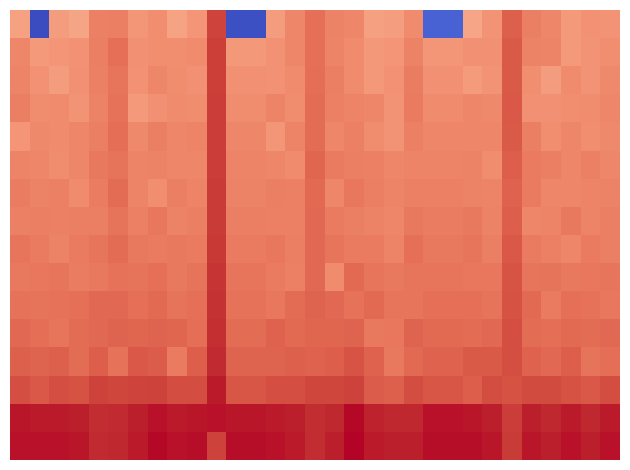

In [4]:
x, u = get_x_u()

#u_magnitude = np.abs(u)

# Create a figure and axes with no background
fig, ax = plt.subplots(facecolor='none')
ax.axis('off')  # Remove axes

# Plot the data with a colormap and alpha
#im = ax.imshow(u_magnitude, cmap='plasma')
im = ax.specgram(x, cmap="coolwarm", NFFT=30, noverlap=0)
# Add a colorbar
#fig.colorbar(im, ax=ax)

# Show the plot
plt.tight_layout()
plt.savefig("stft.png")

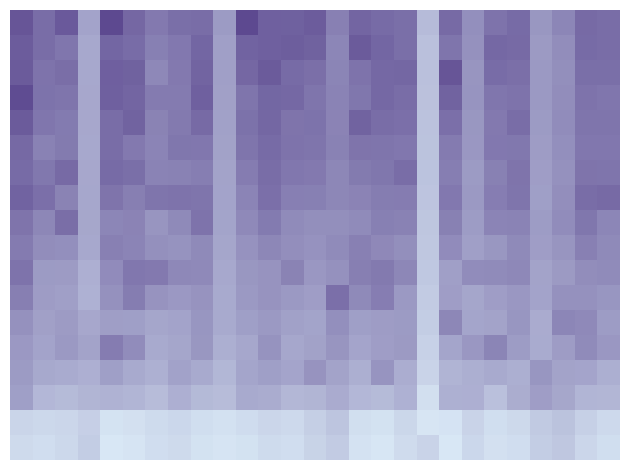

In [5]:
from matplotlib.colors import LinearSegmentedColormap

# Define the colors for the colormap
colors = ["#351c75", "#cfe2f3ff"]  # Blue to Purple

# Create the colormap
cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)

x, u = get_x_u()

# Create a figure and axes with no background
fig, ax = plt.subplots(facecolor='none')
ax.axis('off')  # Remove axes

# Plot the data with the custom colormap and alpha
im = ax.specgram(x, cmap=cmap, NFFT=34, interpolation="none", noverlap=0, alpha=.8)

# Show the plot
plt.tight_layout()
plt.savefig("stft.png")

(array([[4.57486303e+00, 8.72748307e+00, 3.16684636e+00, 5.38752684e-01,
         1.36788239e+01, 2.91528497e+01, 1.42389777e+01, 4.60746841e+00,
         4.75571374e+00, 1.43458264e+01, 1.15245207e+01, 1.63907078e+01,
         7.91323317e+00, 4.22317316e+00, 7.86983107e+00, 6.64388803e-01,
         7.18742382e-01, 1.22276120e+01, 2.23108309e+01, 7.82097914e+00,
         8.18319977e+00, 4.81966162e+01, 1.38473020e+01, 6.15409447e-01,
         1.38953005e+01, 7.20239031e+00, 4.85399539e-01, 5.55555447e-01,
         8.59577237e-01, 6.83529742e+00, 7.41442797e+00],
        [2.46577051e+00, 5.50110572e+00, 1.57935862e+00, 4.82000054e-01,
         8.61160205e+00, 1.71256907e+01, 7.89744372e+00, 3.76269435e+00,
         2.96000204e+00, 7.92330730e+00, 7.97798327e+00, 8.92103420e+00,
         4.05566830e+00, 2.37131352e+00, 4.29738454e+00, 3.86559664e-01,
         3.06688752e-01, 7.35085988e+00, 1.19848743e+01, 4.27621494e+00,
         4.97038180e+00, 2.70291280e+01, 6.97331647e+00, 1.1923763

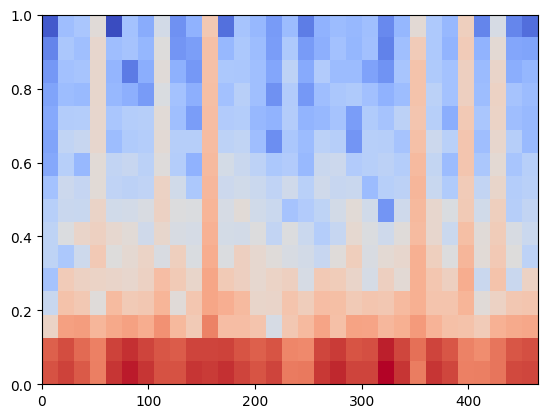

In [6]:
#plt.plot(x)
plt.specgram(x, NFFT=30, noverlap=0, cmap="coolwarm")

In [7]:
from preprocessing.augmentations import Augmenter

config = load_yaml_param_settings("configs/config.yaml")

aug = Augmenter(**config["augmentations"])

x, u = get_x_u()
xaugs = []

for _ in range(100):
    xaug, combination = aug.augment(x, return_combinations=True)
    xaugs.append(xaug)

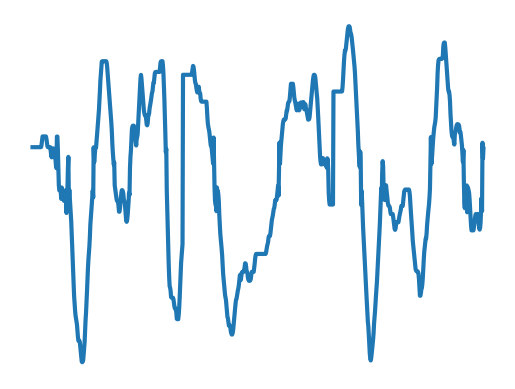

In [8]:
plt.axis('off')
# thicker linewidth
plt.plot(x, label="original", linewidth=3)
plt.savefig("original.png", bbox_inches='tight', transparent=True)

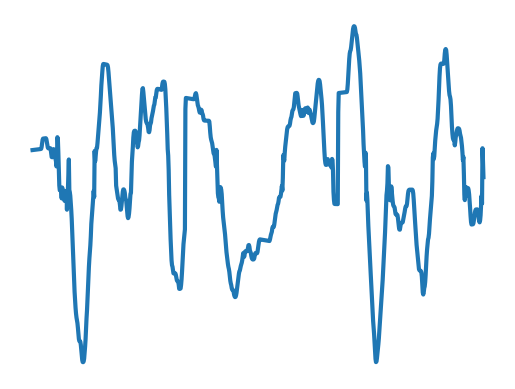

In [9]:
plt.axis('off')
plt.plot(xaugs[70], label="augmented", linewidth=3)
plt.savefig("augmented_signal.png", bbox_inches="tight", transparent=True)

In [10]:
def add_amplitude_resize(*subx_views):
    """
    Apply random amplitude resizing to input sequences.

    Parameters:
    - subx_views: Variable number of input sequences (subseq_len).

    Returns:
    - augmented_views: List of sequences with random amplitude resizing.
    """

    augmented_views = []

    for subx in subx_views:
        subseq_len = subx.shape[0]
        mul_AmpR = 1 + np.random.normal(0, 0.1, size=(subseq_len,))
        augmented_view = subx * mul_AmpR

        augmented_views.append(augmented_view)

    if len(augmented_views) == 1:
        augmented_views = augmented_views[0]

    return augmented_views

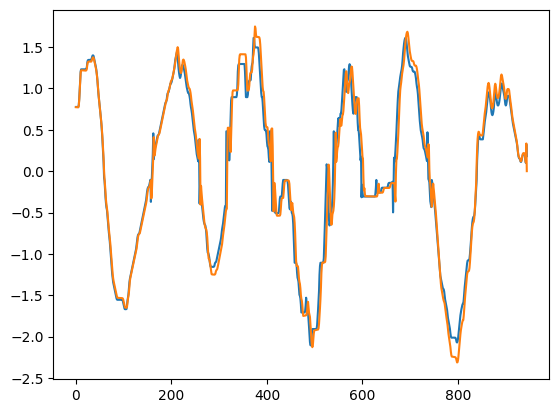

In [11]:
x, u = get_x_u()
xaug = aug.augment(x)
plt.plot(x)
xaug = aug.augment(x)
plt.plot(xaug)

ValueError: num must be an integer with 1 <= num <= 12, not 13

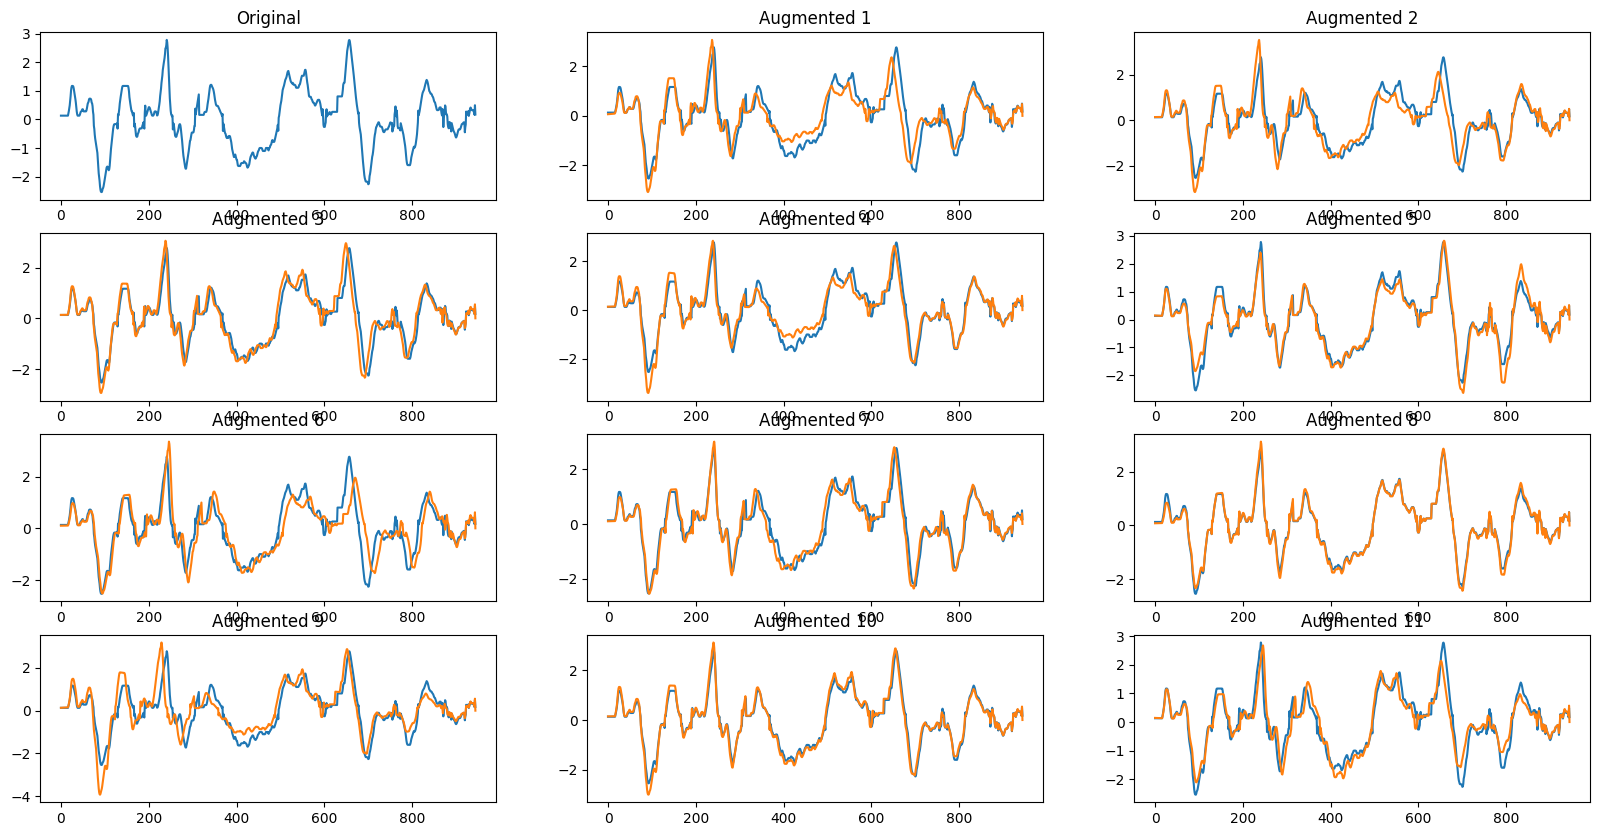

In [85]:
plt.figure(figsize=(20, 10))
plt.subplot(4, 3, 1)
plt.plot(x)
plt.title('Original')

# Plot augmented signals
for i in range(12):
    plt.subplot(4, 3, i+2)
    plt.plot(x, label='Original')
    xaug = aug.augment(x)
    plt.plot(xaug, label='Augmented')
    plt.title(f'Augmented {i+1}')

plt.tight_layout()
plt.show()#plot the original and augmented signals

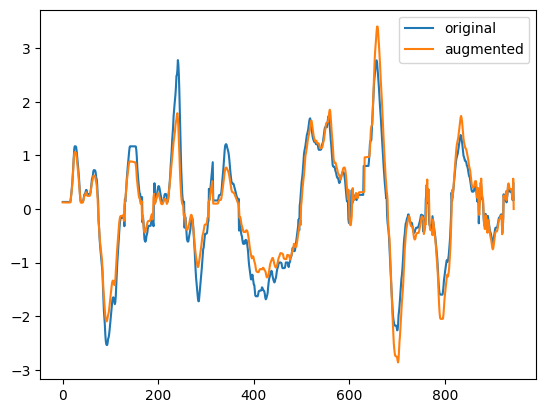

In [83]:

config = load_yaml_param_settings("configs/config.yaml")


aug = Augmenter(**config["augmentations"])


x, _ = get_x_u()
xaug = aug.augment(x)
plt.plot(x, label="original")
plt.plot(xaug, label="augmented")  # Include the augmented signal in the plot
plt.legend()
plt.show()#plot the original and augmented signals

In [ ]:
def add_gaussian_noise(*subx_views, mean=0, variance=1.0):
    """
    Add Gaussian noise to the input sequences.
    """
    noise_subx_views = []

    for subx in subx_views:
        noise = np.random.normal(mean, np.sqrt(variance), subx.shape)
        noise_subx = subx + noise
        noise_subx_views.append(noise_subx)

    if len(noise_subx_views) == 1:
        noise_subx_views = noise_subx_views[0]

    return noise_subx_views

def add_slice_and_shuffle(*subx_views, n_segments=2):
    """
    Slice the input sequences into segments and shuffle them.
    """
    shuffled_subx_views = []

    for subx in subx_views:
        # Randomly pick n_segments-1 points where to slice
        idxs = np.random.randint(0, subx.shape[0], size=n_segments - 1)
        slices = []
        start_idx = 0
        for j in sorted(idxs):
            s = subx[start_idx:j]
            start_idx = j
            slices.append(s)
        slices.append(subx[start_idx:])
        np.random.shuffle(slices)
        shuffled_subx = np.concatenate(slices)
        shuffled_subx_views.append(shuffled_subx)

    if len(shuffled_subx_views) == 1:
        shuffled_subx_views = shuffled_subx_views[0]

    return shuffled_subx_views

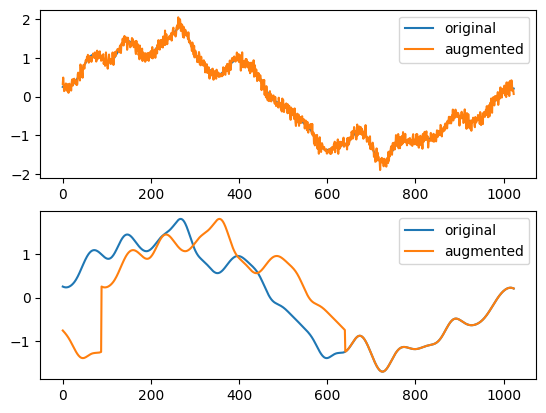

In [ ]:
x, u = get_x_u()

aug_noise = add_gaussian_noise(x, mean=0, variance=0.01)
xaug_shuffled = add_slice_and_shuffle(x, n_segments=4)

f, a = plt.subplots(2)
a[0].plot(x, label="original")
a[0].plot(aug_noise, label="augmented")
a[0].legend()
a[1].plot(x, label="original")
a[1].plot(xaug_shuffled, label="augmented")
a[1].legend()


In [ ]:
import torch
z = torch.rand(128, 64, 5, 15)
dropout = torch.nn.Dropout(0.2)

In [ ]:
print(z.shape)
z_dp = dropout(z)
print(z_dp.shape)

torch.Size([128, 64, 5, 15])
torch.Size([128, 64, 5, 15])


In [ ]:
print(z)
print(z_dp)

tensor([[[[0.9121, 0.0974, 0.3334,  ..., 0.5036, 0.2222, 0.6209],
          [0.7883, 0.9012, 0.8439,  ..., 0.1269, 0.0154, 0.7028],
          [0.3365, 0.6811, 0.1651,  ..., 0.7181, 0.3767, 0.3977],
          [0.1179, 0.6397, 0.9004,  ..., 0.0399, 0.8245, 0.3432],
          [0.7794, 0.8264, 0.4546,  ..., 0.9420, 0.3832, 0.7714]],

         [[0.8013, 0.2249, 0.0675,  ..., 0.3264, 0.8043, 0.9256],
          [0.5027, 0.0298, 0.9306,  ..., 0.0864, 0.2650, 0.8633],
          [0.1178, 0.6005, 0.2882,  ..., 0.7432, 0.4135, 0.2315],
          [0.5250, 0.5598, 0.3738,  ..., 0.0615, 0.0303, 0.7815],
          [0.8716, 0.4091, 0.7113,  ..., 0.9643, 0.3035, 0.7926]],

         [[0.2169, 0.3830, 0.7727,  ..., 0.1388, 0.1614, 0.8720],
          [0.6576, 0.0967, 0.4742,  ..., 0.6310, 0.3355, 0.4208],
          [0.7003, 0.3688, 0.2352,  ..., 0.8088, 0.3408, 0.6670],
          [0.9365, 0.5434, 0.1746,  ..., 0.5749, 0.9674, 0.9420],
          [0.8486, 0.7256, 0.6719,  ..., 0.1269, 0.1750, 0.8298]],

    

In [ ]:
a = torch.rand(10)
a_dp = dropout(a)

print(a)
print(a_dp)

tensor([0.9515, 0.2044, 0.2085, 0.3865, 0.4253, 0.4732, 0.2744, 0.7958, 0.8605,
        0.2422])
tensor([1.1893, 0.2555, 0.2606, 0.0000, 0.5316, 0.5915, 0.0000, 0.9947, 1.0756,
        0.3028])
